In [1]:
import numpy as np
import sympy as sp
from sympy import Symbol
from sympy import solve, Poly, Eq, Function, exp
import math
import matplotlib.pyplot as plt
from numpy.lib.scimath import sqrt as csqrt
from scipy.signal import find_peaks
import os
import imp
import matplotlib.pyplot as plt
import sys
os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\')
lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py') 

## Theorical Values

In [298]:
def bandwidth(wavelength, response):
    for i in range(len(wavelength)):
        if (10*np.log10(response[i])<-3 and 10*np.log10(response[i+1])>-3):
            min_index = i
            break
    
    for j in range(min_index,len(wavelength)):
        if (10*np.log10(response[j])>-3 and 10*np.log10(response[j+1])<-3):
            max_index = j
            break
    return wavelength[min_index], wavelength[max_index]

In [2]:
mode = lumapi.MODE(filename= 'Bragg.lms')

In [80]:
pi = np.pi
lambda_b = 1560e-9
neff = 2.257669
ng = 4.606681
bandwidth = 20e-9
w = 0.45e-6
delta_w = 0.05e-6
period = lambda_b/(2*neff)
N = 150
L = N*period
kappa = np.sqrt(bandwidth**2*pi**2*ng**2/lambda_b**4 - (pi/L)**2)
r_max = np.tanh(kappa*L)
delta_n = kappa*lambda_b/2
print(period)
print(L)
print(kappa)
print(r_max)
print(delta_n)

3.4548908630981784e-07
5.1823362946472676e-05
102328.89906986506
0.9999504700458737
0.07981654127449475


In [76]:
mode.switchtolayout()
mode.deleteall()

mode.addrect()
mode.set({"name":"guide1",
"x":0,
"x span":period/2,
"y":0,
"y span":w + delta_w,
"z":0,
"z span":0.22e-6,
"material":'Si (Silicon) - Palik'})

mode.addrect()
mode.set({"name":"guide2",
"x":period/4 + period/4,
"x span":period/2,
"y":0,
"y span":w - delta_w,
"z":0,
"z span":0.22e-6,
"material":'Si (Silicon) - Palik'})


mode.addrect()
mode.set({"name":"guide_before",
"x max":-period/4,
"x min":-period/4-0.5e-6,
"y":0,
"y span":w,
"z":0,
"z span":0.22e-6,
"material":'Si (Silicon) - Palik'})

mode.addrect()
mode.set({"name":"guide_after",
"x max":period/4 + period/4 + period/4 + 0.5e-6,
"x min":period/4 + period/4 + period/4,
"y":0,
"y span":w,
"z":0,
"z span":0.22e-6,
"material":'Si (Silicon) - Palik'})

mode.addrect()
mode.set({"name":"substrato",
"x":0,
"x span":2e-6,
"y":0,
"y span":2e-6,
"z min":-2.11e-6})
mode.setnamed("substrato","z min",-2.11e-6)
mode.setnamed("substrato","z max",-0.11e-6)
mode.setnamed("substrato","material","SiO2 (Glass) - Palik")

In [125]:
mode.switchtolayout()
mode.select("FDE")
mode.delete()
mode.select("mesh")
mode.delete()
mode.addfde()
mode.setnamed("FDE","solver type","2D X normal")
mode.set({"x":0,
"y":0,
"y span":3e-6,
"z":0,
"z span":3e-6,
"mesh cells y":150,
"mesh cells z":150})

mode.addmesh()
mode.set({"x":0,
"x span":0.1e-6,
"y":0,
"y span":0.6e-6,
"z":0,
"z span":0.3e-6})
mode.set({"override x mesh":0,
"dy":0.005e-6,
"dz":0.005e-6})

mode.addmesh()
mode.set({"x":period/4 + period/4,
"x span":0.1e-6,
"y":0,
"y span":0.6e-6,
"z":0,
"z span":0.3e-6})
mode.set({"override x mesh":0,
"dy":0.005e-6,
"dz":0.005e-6})

{!!}



In [126]:
number_of_points = 10
neff_1 = np.zeros(number_of_points)
neff_2 = np.zeros(number_of_points)
dw = np.linspace(0, 0.08e-6, number_of_points)
for i in range(len(dw)):
    mode.switchtolayout()
    mode.setnamed("FDE","x",0)
    mode.setnamed("guide1","y span", w + dw[i])
    mode.findmodes()
    neff_1[i] = np.real(mode.getdata('FDE::data::mode1','neff'))

for j in range(len(dw)):
    mode.switchtolayout()
    mode.setnamed("FDE","x",period/4 + period/4)
    mode.setnamed("guide2","y span", w - dw[j])
    mode.findmodes()
    neff_2[j] = np.real(mode.getdata('FDE::data::mode1','neff'))

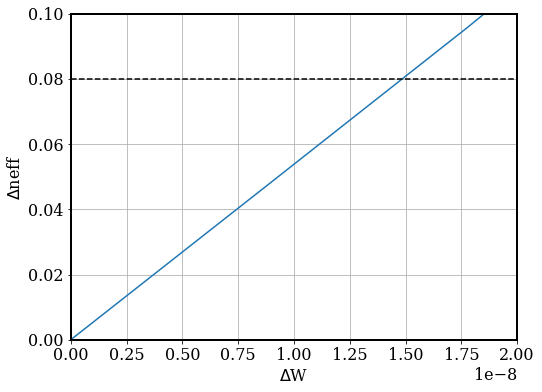

In [175]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
figure = plt.figure(figsize=(8,6))
plt.plot(dw, neff_1 - neff_2)
plt.axhline(y = delta_n, xmax = 1.5, linestyle = '--', color = "black")
plt.xlim([0, 2e-8])
plt.ylim([0, 0.1])
plt.xlabel("$\Delta$W")
plt.ylabel("$\Delta$neff")
plt.grid(True)

Text(0.5, 1.0, '$\\Delta$W = 14.8 nm')

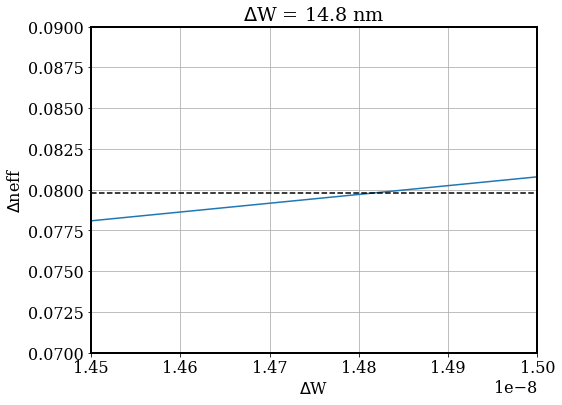

In [184]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
figure = plt.figure(figsize=(8,6))
plt.plot(dw, neff_1 - neff_2)
plt.axhline(y = delta_n, xmax = 1.5, linestyle = '--', color = "black")
plt.xlim([1.45e-8, 1.5e-8])
plt.ylim([0.07, 0.09])
plt.xlabel("$\Delta$W")
plt.ylabel("$\Delta$neff")
plt.grid(True)
plt.title("$\Delta$W = 14.8 nm")

In [187]:
mode.switchtolayout()
mode.setnamed("guide1","y span", w + 14.8e-9)
mode.setnamed("guide2","y span", w - 14.8e-9)


In [188]:
mode.switchtolayout()
mode.select("EME")
mode.delete()
mode.addeme()
mode.setnamed("EME","x min",-period/4-0.25e-6)
mode.set({"y":0,
"y span":2e-6,
"z":0,
"z span":2e-6})
#mode.set("allow custom eigensolver settings",1)
mode.set("number of cell groups",4) 
mode.set("number of modes for all cell groups", 10)
mode.set("group spans", np.transpose([0.25e-6, period/2,period/2,0.25e-6]))
mode.set({"y min bc":"PML",
"y max bc":"PML",
"z min bc":"PML",
"z max bc":"PML",
"mesh cells z":100,
"mesh cells y":100})


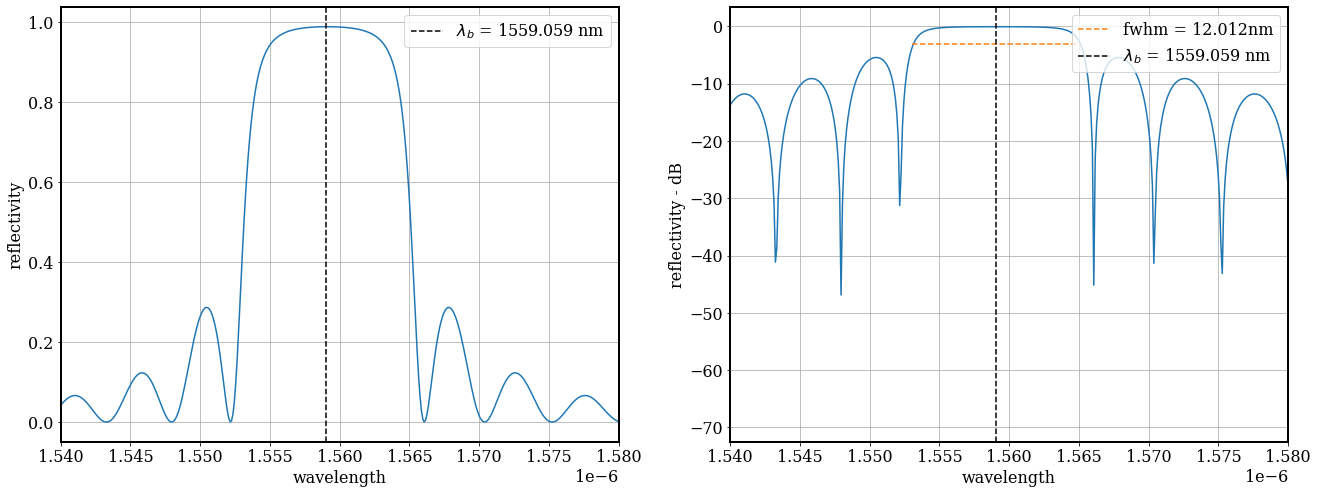

In [335]:
S_parameters = mode.getemesweep("S_wavelength_sweep")
s11= abs(S_parameters['s11']**2)
wavelength = S_parameters['wavelength']

peak = find_peaks(s11, height=0.5)
peak_pos = wavelength[peak[0]]
band = bandwidth(wavelength, s11)
fwhm = band[1] - band[0]

figure, ax = plt.subplots(1, 2, figsize=(22,8))

plt.rc('font', **font)
plt.rc('axes', linewidth=2)
ax[0].plot(wavelength, s11)
ax[0].axvline(x = peak_pos, linestyle = '--',color = 'black', label ='$\lambda_b$ = ' + str(round(peak_pos[0][0]*1e9, 3))+" nm")
ax[0].set_xlim([1.54e-6, 1.58e-6])
#plt.ylim([0.07, 0.09])
ax[0].set_xlabel("wavelength")
ax[0].set_ylabel("reflectivity")
ax[0].grid(True)
ax[0].legend(loc = 'upper right')

ax[1].plot(wavelength, 10*np.log10(s11))
ax[1].plot([band[0], band[1]], [-3, -3], '--', label = "fwhm = " + str(round(fwhm[0]*1e9, 3)) + 'nm')
ax[1].axvline(x = peak_pos, linestyle = '--',color = 'black', label ='$\lambda_b$ = ' + str(round(peak_pos[0][0]*1e9, 3))+" nm")
ax[1].set_xlim([1.54e-6, 1.58e-6])
#plt.ylim([0.07, 0.09])
ax[1].set_xlabel("wavelength")
ax[1].set_ylabel("reflectivity - dB")
ax[1].grid(True)
ax[1].legend(loc = 'upper right')


In [328]:
np.mean(wavelength)

1.55e-06

In [282]:
bandwidth(wavelenght, s11)

array([9.43584489e-05, 2.11983590e-05, 2.96412431e-07, 3.25828010e-05,
       1.18023076e-04, 2.55612915e-04, 4.43391445e-04, 6.78472890e-04,
       9.57095928e-04, 1.27468972e-03, 1.62595523e-03, 2.00496019e-03,
       2.40524565e-03, 2.81994210e-03, 3.24189272e-03, 3.66378148e-03,
       4.07826366e-03, 4.47809637e-03, 4.85626685e-03, 5.20611629e-03,
       5.52145719e-03, 5.79668242e-03, 6.02686419e-03, 6.20784156e-03,
       6.33629520e-03, 6.40980826e-03, 6.42691243e-03, 6.38711871e-03,
       6.29093204e-03, 6.13984988e-03, 5.93634424e-03, 5.68382756e-03,
       5.38660249e-03, 5.04979627e-03, 4.67928025e-03, 4.28157566e-03,
       3.86374680e-03, 3.43328308e-03, 2.99797164e-03, 2.56576261e-03,
       2.14462905e-03, 1.74242409e-03, 1.36673787e-03, 1.02475682e-03,
       7.23128257e-04, 4.67832963e-04, 2.64068450e-04, 1.16145511e-04,
       2.74003750e-05, 1.24529667e-07, 3.55138700e-05, 1.33638456e-04,
       2.93433665e-04, 5.12713050e-04, 7.88202704e-04, 1.11559644e-03,
      